In [426]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

# Loading and understanding the data

In [291]:
train_path = './house_price_data/train.csv'
test_path = './house_price_data/test.csv' 

In [292]:
data_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

81 features -> 79 features column (except `target` and `id`)

In [293]:
print(data_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


In [294]:
data_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [295]:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice'>

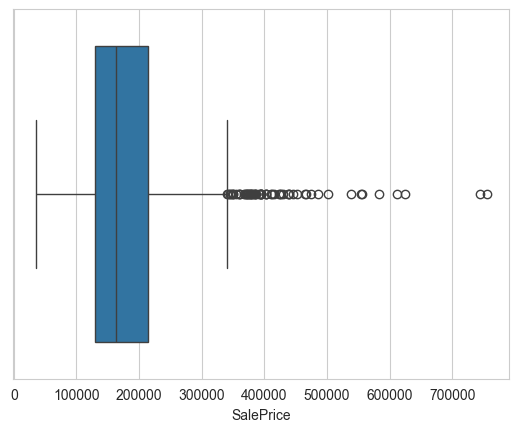

In [296]:
sns.boxplot(x = data_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Density'>

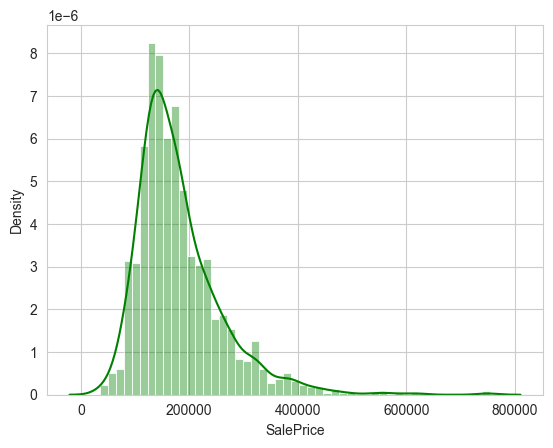

In [297]:
sns.histplot(data_df['SalePrice'], kde=True, stat='density', color='g', alpha=0.4, kde_kws=dict(cut=3))

Right-skewed distribution with the pick around 160k and long tail with maximum around 800k

In [298]:
data_df['SalePrice'].skew()

1.8828757597682129

Text(171.72222222222234, 0.5, 'Features')

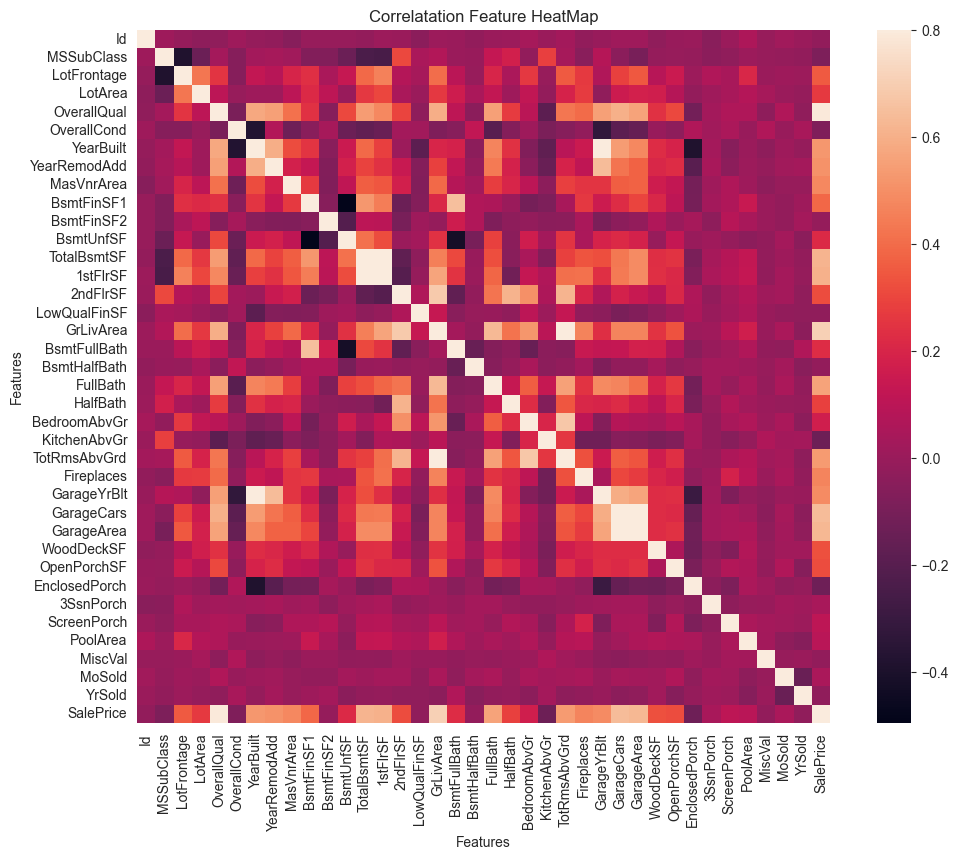

In [299]:
#correlation matrix
corr_mat = data_df.corr(numeric_only=True)
plt.figure(figsize=(12, 9))

sns.heatmap(corr_mat, vmax=.8,square=True)

plt.title("Correlatation Feature HeatMap")
plt.xlabel("Features")
plt.ylabel("Features")

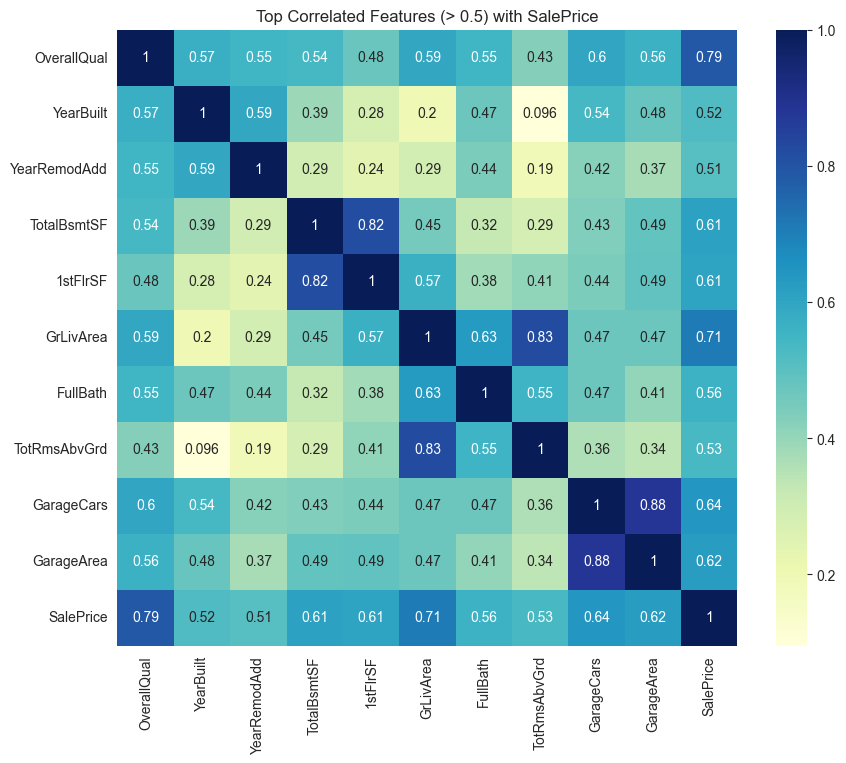

In [300]:
corr_mat = data_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))

top_corr = corr_mat.index[abs(corr_mat['SalePrice'])>0.5]
sns.heatmap(data_df[top_corr].corr(), annot=True, cmap='YlGnBu')
plt.title("Top Correlated Features (> 0.5) with SalePrice")
plt.show()

- OverallQual and GrLivArea seem to be the most correlated to SalePrice

In [301]:
corr = data_df.corr(numeric_only=True).drop('SalePrice')
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
print(corr.SalePrice)

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


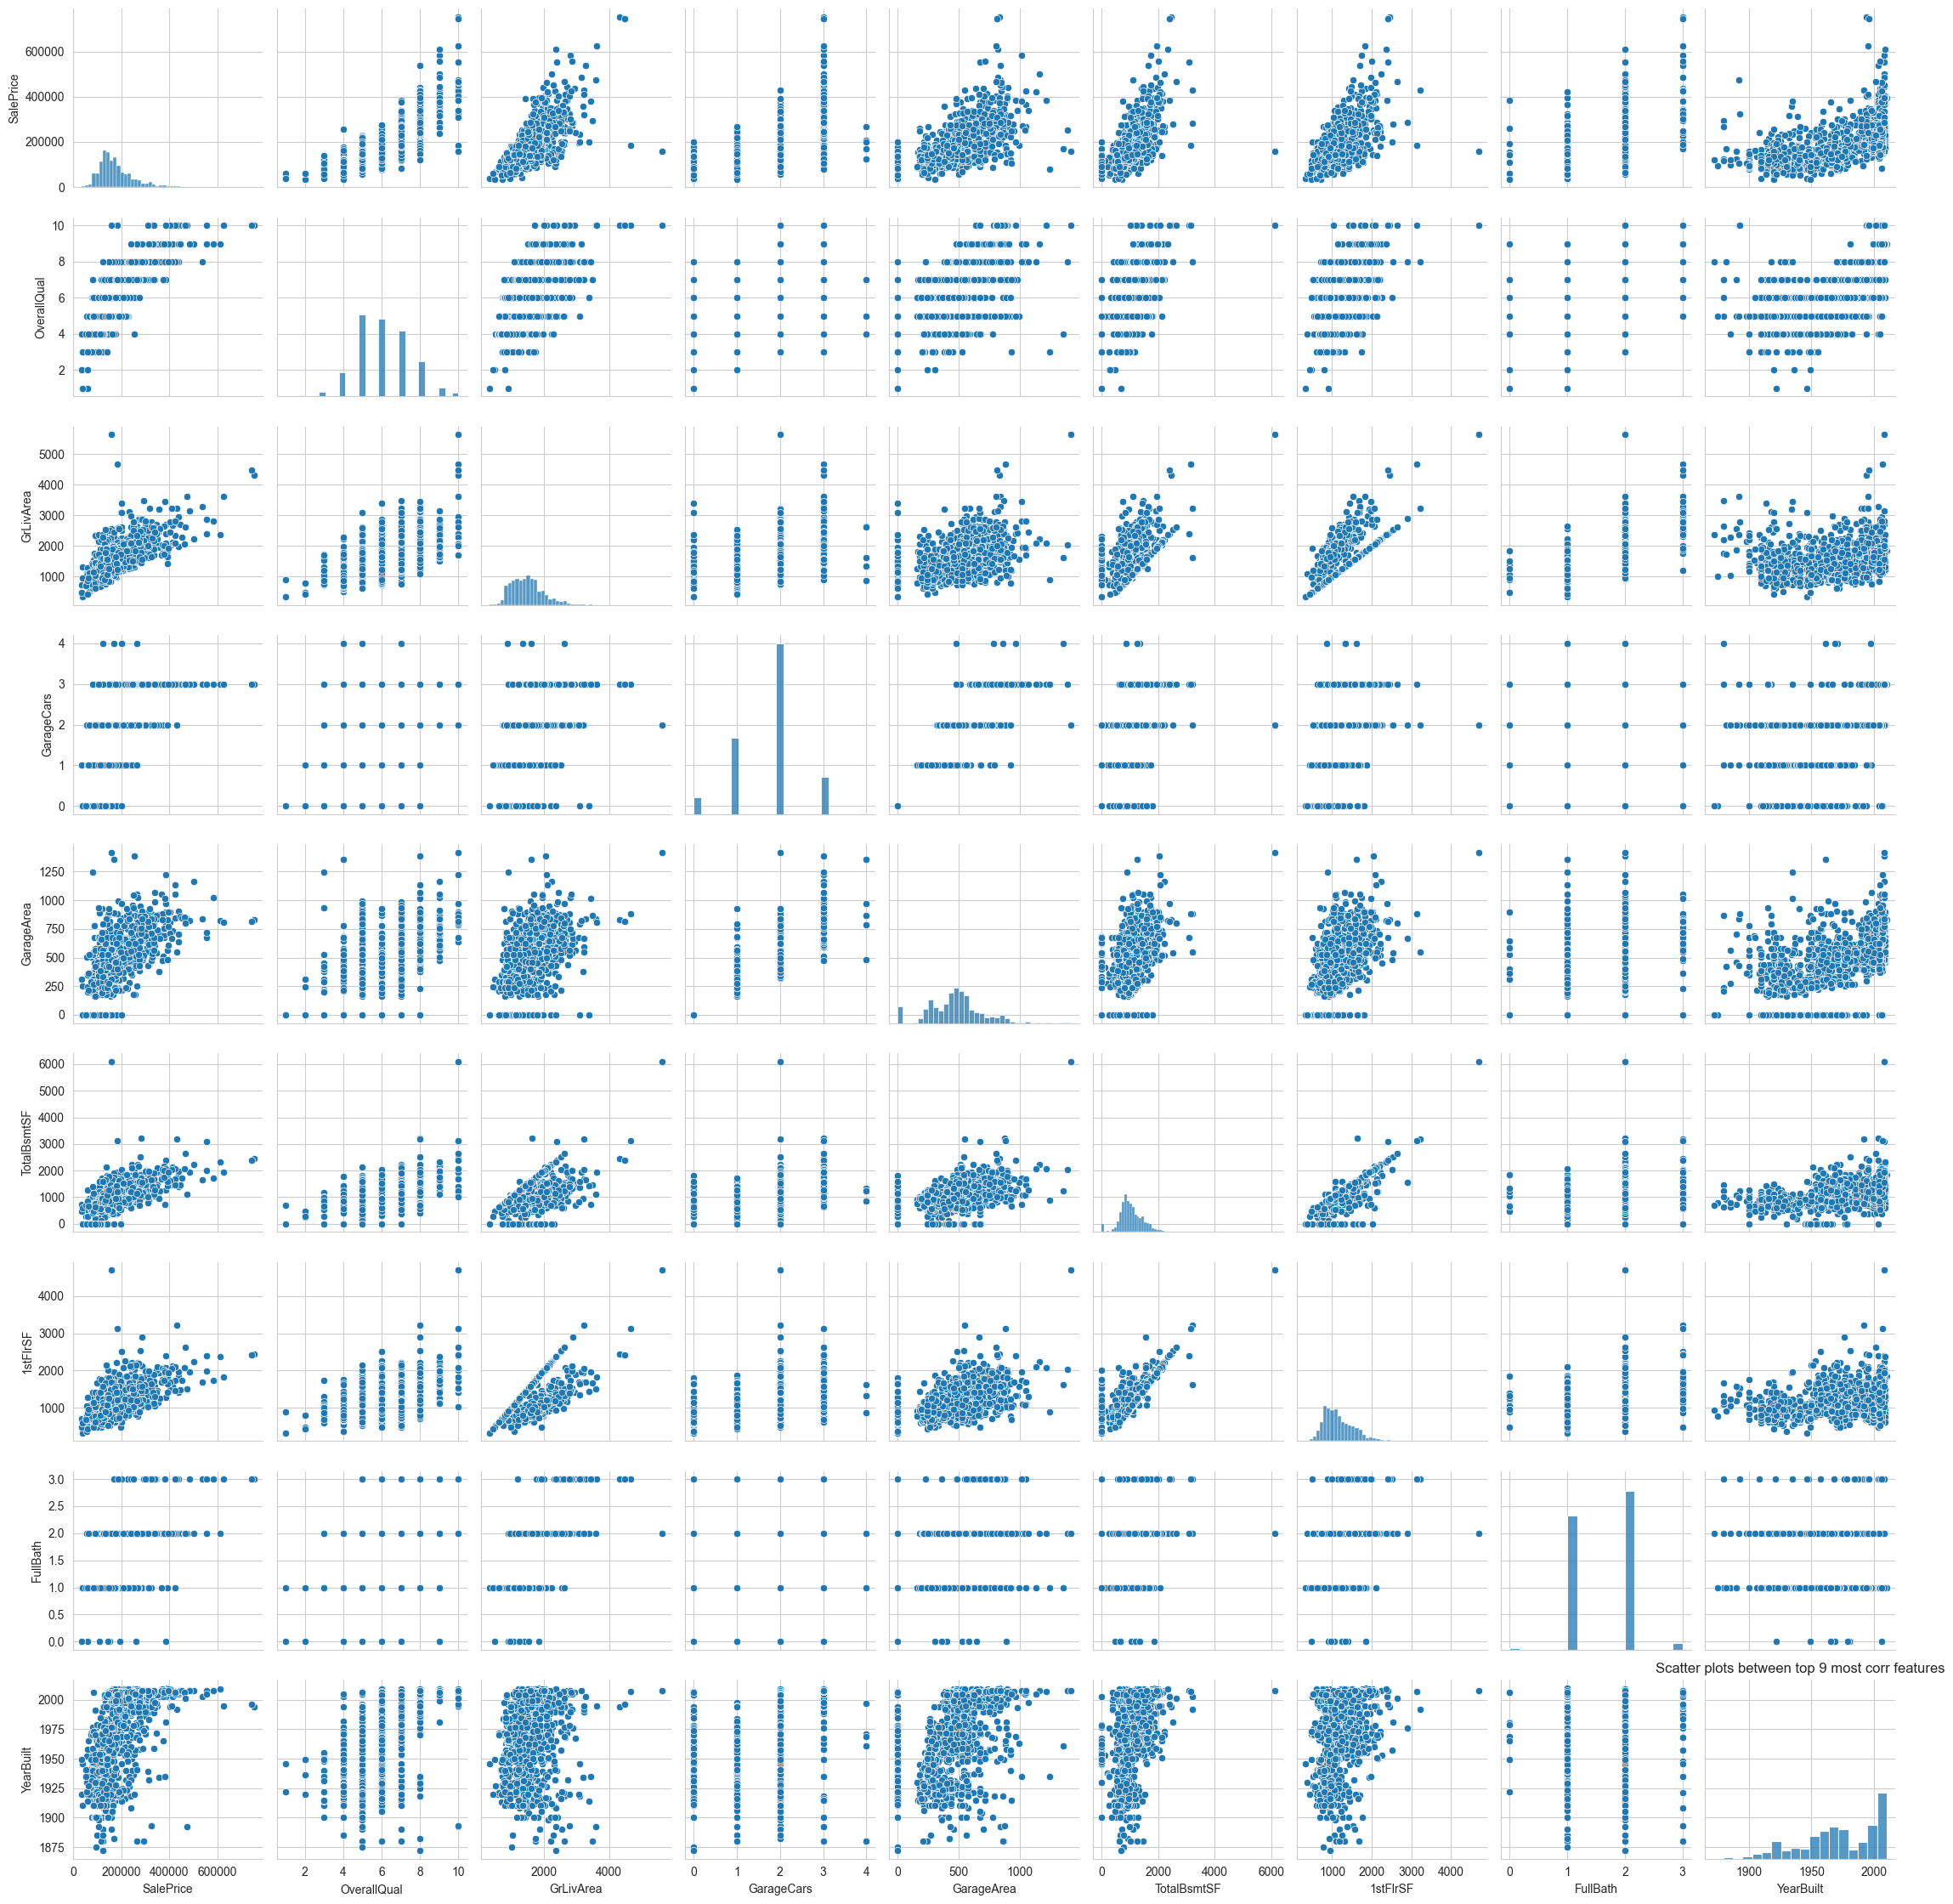

In [302]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea', 'TotalBsmtSF','1stFlrSF','FullBath','YearBuilt']
sns_plot = sns.pairplot(data_df[cols])

plt.title('Scatter plots between top 9 most corr features')
plt.tight_layout()
plt.show()

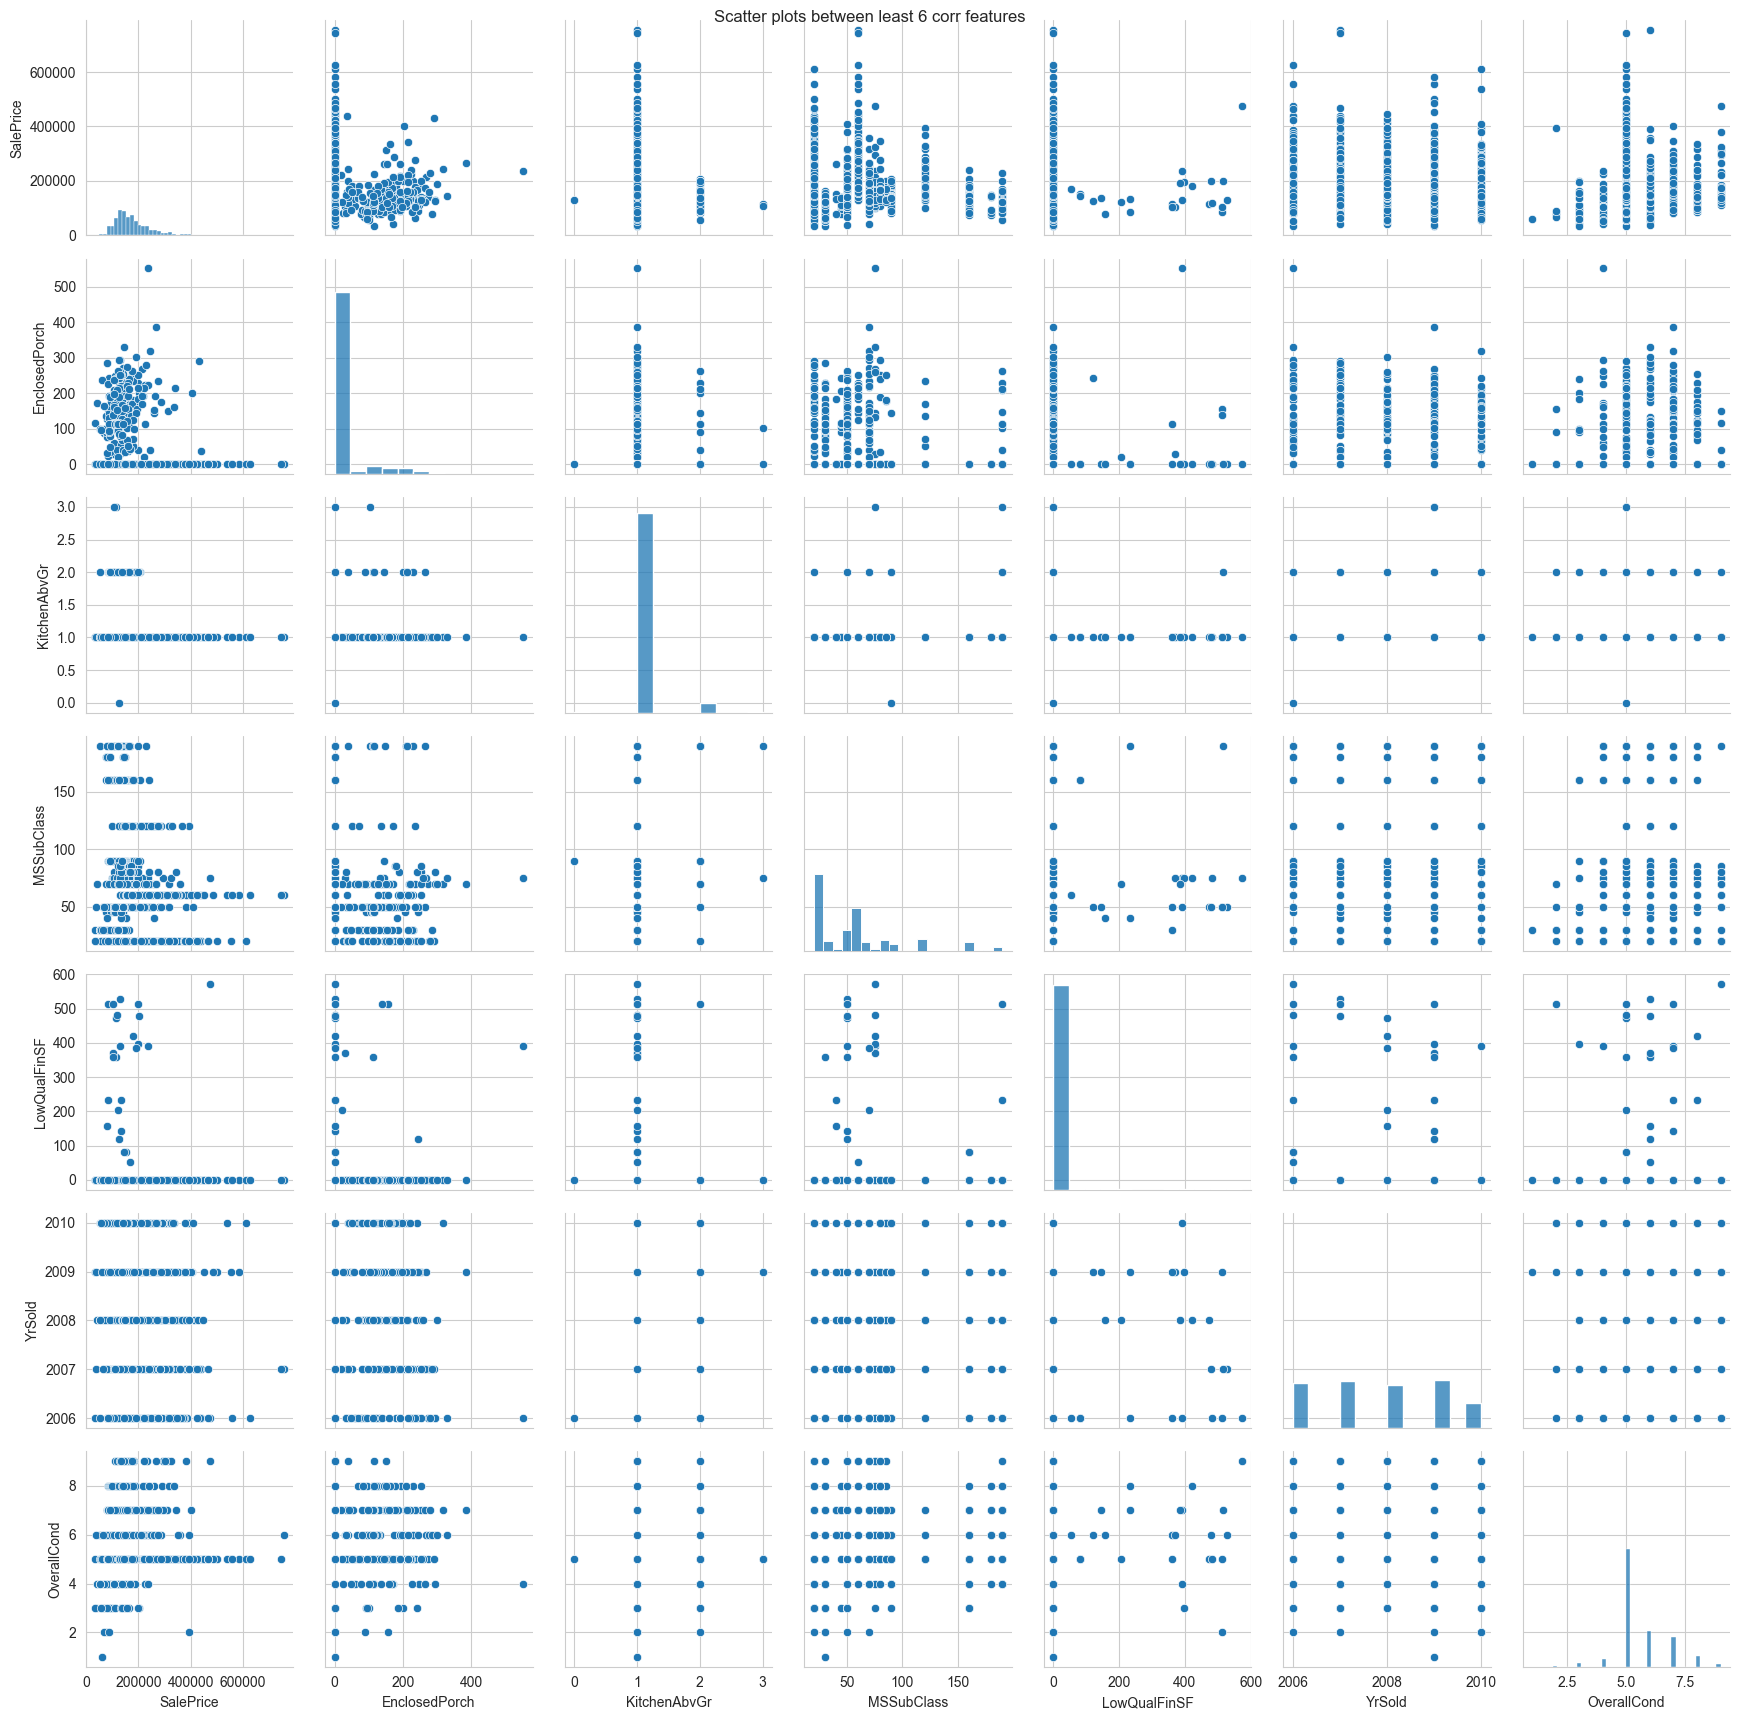

In [303]:
cols = ['SalePrice','EnclosedPorch', 'KitchenAbvGr', 'MSSubClass', 'LowQualFinSF','YrSold', 'OverallCond']
sns_plot = sns.pairplot(data_df[cols])

plt.suptitle('Scatter plots between least 6 corr features')
plt.tight_layout()
plt.show()

# Handing Data

In [304]:
train_id = data_df['Id']
test_id = test_df['Id']

data_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

data_df.shape, test_df.shape

((1460, 80), (1459, 79))

## Handling outliers


In [305]:
edgecolor = 'black'
sns.set_style('whitegrid') 

def scatter_plot_with_sale_price(column_name):
    plt.scatter(data_df[column_name], data_df['SalePrice'], edgecolor=edgecolor)
    plt.xlabel(column_name)
    plt.ylabel('SalePrice')
    plt.title(f'Scatter plot of {column_name} vs SalePrice')
    plt.show()

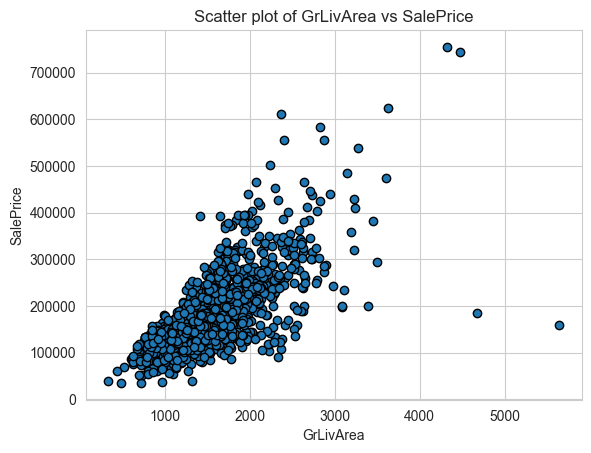

In [306]:
scatter_plot_with_sale_price('GrLivArea')

- Some outliers can negatively affect the prediction highly -> should delete them

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

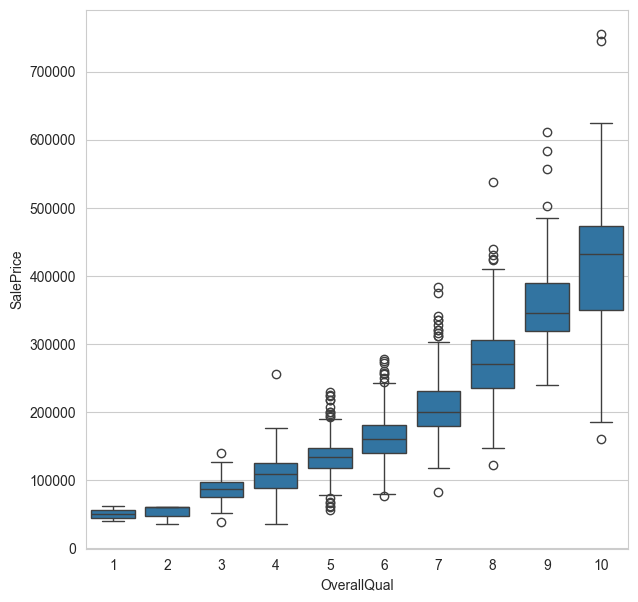

In [307]:
# plot a box for categorical features: OverallQual

plt.figure(figsize=(7, 7))
data = pd.concat([data_df['SalePrice'], data_df['OverallQual']], axis=1)
sns.boxplot(x=data_df['OverallQual'], y='SalePrice', data=data)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111],
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0,

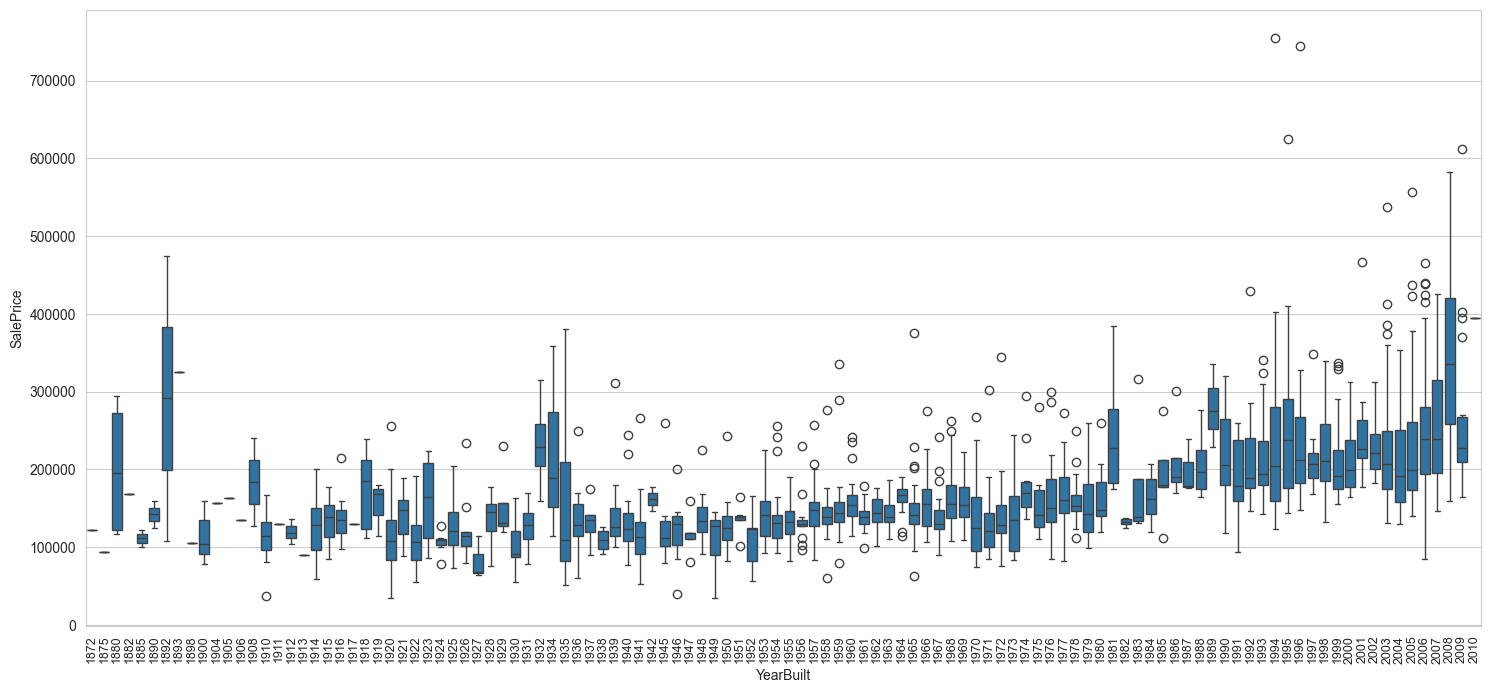

In [308]:
plt.figure(figsize=(18, 8))

data = pd.concat([data_df['SalePrice'], data_df['YearBuilt']], axis=1)
sns.boxplot(x='YearBuilt', y='SalePrice', data=data)
plt.xticks(rotation=90, fontsize=9)

Skewness: 1.882876
Kurtosis: 6.536282


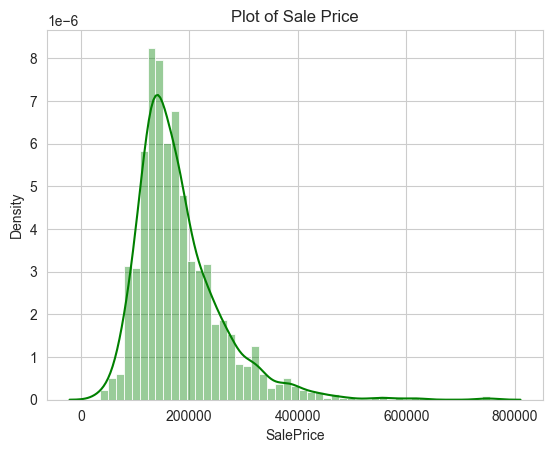

In [309]:
sns.histplot(data_df['SalePrice'], kde=True, stat='density', color='g', alpha=0.4, kde_kws=dict(cut=3))
plt.title( "Plot of Sale Price")

print("Skewness: %f" % data_df['SalePrice'].skew())
print("Kurtosis: %f" % data_df['SalePrice'].kurt())

Using Logarithm transformation to reduce skew

Text(0.5, 1.0, 'Plot of Sale Price after log transformation')

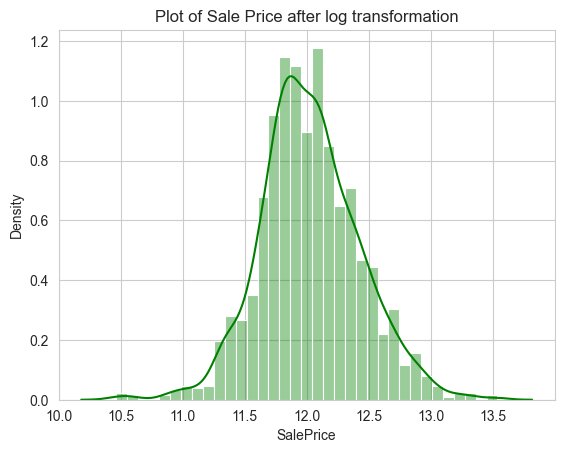

In [310]:
data_df['SalePrice'] = np.log(data_df['SalePrice'])
# new distribution
sns.histplot(data_df['SalePrice'], kde=True, stat='density', color='g', alpha=0.4, kde_kws=dict(cut=3))
plt.title('Plot of Sale Price after log transformation')

In [311]:
data_df['SalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

## Handling missing data

In [312]:
def missing_data(df,n):    
    total = df.isnull().sum().sort_values(ascending=False)          # Total No of missing values
    percentage = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)*100  # % of Missing values
    unique_val = df.nunique()                                   # No of unique values
    missing_data = pd.concat([total, percentage,unique_val], axis=1, 
                             keys=['Total No of missing val', '% of Missing val','No of unique val'], sort = False)
    
    return missing_data.head(n)

In [313]:
missing_data(data_df, 20)

,Total No of missing val,% of Missing val,No of unique val
PoolQC,1453,99.520548,3
MiscFeature,1406,96.301370,4
Alley,1369,93.767123,2
Fence,1179,80.753425,4
MasVnrType,872,59.726027,3
FireplaceQu,690,47.260274,5
LotFrontage,259,17.739726,110
GarageYrBlt,81,5.547945,97
GarageCond,81,5.547945,5
GarageType,81,5.547945,6


- PoolQC, Alley have only two unique values
- PoolQC has 99.7% of missing data, which means most of the values are NA
- PoolQC, Alley, MiscFeature will be dropped due to large number of missing values

In [314]:
unique_vals = data_df.nunique()
pd.concat([unique_vals.sort_values(ascending=True)], axis=1, keys=['No of unique val'])

,No of unique val
Street,2
Alley,2
Utilities,2
CentralAir,2
HalfBath,3
...,...
TotalBsmtSF,721
1stFlrSF,753
BsmtUnfSF,780
GrLivArea,861


In [315]:
cols = ['Alley', 'Street', 'Utilities', 'CentralAir']
unique_vals = {col: (', '.join(str(val) for val in data_df[col].unique())) for col in cols}

pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_vals.items()]))

,Alley,Street,Utilities,CentralAir
0,"nan, Grvl, Pave","Pave, Grvl","AllPub, NoSeWa","Y, N"


In [316]:
def plot_pie_chart(df, cols):
    n = len(cols)
    ncols = 4
    nrows = (n + 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        value_counts = df[col].value_counts(dropna=False)
        labels = ['NaN' if pd.isna(val) else str(val) for val in value_counts.index]
        axes[i].pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Pie Chart of {col}')

    plt.tight_layout()
    plt.show()

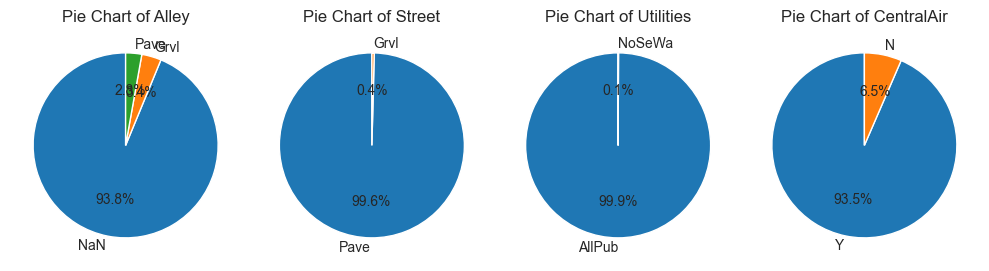

In [317]:
plot_pie_chart(data_df, cols)

- Street and Utilities have skewed distribution

<Axes: xlabel='Street', ylabel='SalePrice'>

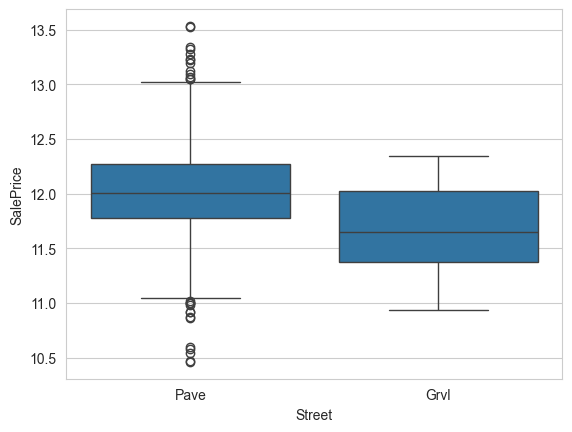

In [318]:
sns.boxplot(data=data_df, x='Street', y='SalePrice')

- all records mostly "AllPub" for Utilities
- PoolQC,Alley,MiscFeature will be dropped due to large number of missing values

In [319]:
# HANDLE the missing data in other columns
def handle_missing (df):
    
    # drop theses columns due to large null values or many same values
    df = df.drop(['Utilities','PoolQC','MiscFeature','Alley'], axis=1)
    
    # Null value likely means No Fence so fill as "None"
    df["Fence"] = df["Fence"].fillna("None") 
    
    # Null value likely means No Fireplace so fill as "None"
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    
    # Lot frontage is the feet of street connected to property, which is likely similar to the neighbourhood houses, so fill Median value
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    
    # Null value likely means  typical(Typ)
    df["Functional"] = df["Functional"].fillna("Typ")
    
    # Only one null value so fill as the most frequent value(mode)
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])  
    
    # Only one null value so fill as the most frequent value(mode)
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    
    # Very few null value so fill with the most frequent value(mode)
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    # Null value likely means no masonry veneer
    df["MasVnrType"] = df["MasVnrType"].fillna("None") #so fill as "None" (since categorical feature)
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)      #so fill as o
    
    # Only one null value so fill as the most frequent value(mode)
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    #MSZoning is general zoning classification,Very few null value so fill with the most frequent value(mode)
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    
    #Null value likely means no Identified type of dwelling so fill as "None"
    df['MSSubClass'] = df['MSSubClass'].fillna("None")
    
    # Null value likely means No Garage, so fill as "None" (since these are categorical features)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df[col] = df[col].fillna('None')
    
    # Null value likely means No Garage and no cars in garage, so fill as 0
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
    
    # Null value likely means No Basement, so fill as "None" (since these are categorical features)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
    
    return df

In [320]:
data_df = handle_missing(data_df)
test_df = handle_missing(test_df)

In [321]:
data_null = data_df.isnull().sum().sum()

test_null = test_df.isnull().sum().sum()

data_null, test_null

(0, 0)

In [340]:
data_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [323]:
def add_new_cols(df):
    
    df['Total_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] 
                             + (0.5 * df['BsmtHalfBath']))

    df['Total_Porch_SF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + 
                            df['ScreenPorch'] + df['WoodDeckSF'])

    df['Total_Square_Feet'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    
    df['Total_Quality'] = df['OverallQual'] + df['OverallCond']
    
    return df

In [324]:
data_df = add_new_cols(data_df)
test_df = add_new_cols(test_df)

## Check data types

In [325]:
gr = data_df.columns.to_series().groupby(data_df.dtypes).groups
{k.name: v for k, v in gr.items()}

{'int64': Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
        'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold', 'Total_SF', 'Total_Porch_SF',
        'Total_Square_Feet', 'Total_Quality'],
       dtype='object'),
 'float64': Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice',
        'Total_Bathrooms'],
       dtype='object'),
 'object': Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
        'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
        'MasVnrT

# Transformation data

In [326]:
categorical_features = data_df.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']


In [327]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded_data = onehot_encoder.fit_transform(data_df[categorical_features])

In [328]:
onehot_df = pd.DataFrame(one_hot_encoded_data, columns=onehot_encoder.get_feature_names_out(categorical_features))
data_df_encoded = pd.concat([data_df.drop(categorical_features, axis=1), onehot_df], axis=1)
data_df_encoded.shape

(1460, 294)

In [329]:
test_onehot_df = pd.DataFrame(onehot_encoder.transform(test_df[categorical_features]), columns=onehot_encoder.get_feature_names_out(categorical_features))
test_df_encoded = pd.concat([test_df.drop(categorical_features, axis=1), test_onehot_df], axis=1)
test_df_encoded.shape

(1459, 293)

In [364]:
train_set, valid_set = train_test_split(data_df_encoded, train_size=0.7, random_state=42, shuffle=False)

X_train = train_set.drop(['SalePrice'], axis=1)
y_train = train_set['SalePrice'].copy()

X_valid = valid_set.drop(['SalePrice'], axis=1)
y_valid = valid_set['SalePrice'].copy()

X_test = test_df_encoded.copy()

In [365]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print()
print("X_valid shape: {}".format(X_valid.shape))
print("y_valid shape: {}".format(y_valid.shape))
print()
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1021, 293)
y_train shape: (1021,)

X_valid shape: (439, 293)
y_valid shape: (439,)

X_test shape: (1459, 293)


# Set metrics

## Cross Validation

In [377]:
def cross_validation(model, X_train, y_train):
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
    mean = np.mean(scores)
    print(f'{model.__class__.__name__} Mean CV scores: {mean}')

In [378]:
def rmse(y_pred, y_true):
    rmse_ = np.sqrt(mean_squared_error(y_pred, y_true))
    print(f'RMSE: {rmse_}')

In [395]:
def pred_vs_actual_plot(y_pred, y_true):

    plt.figure(figsize=(12, 12))

    plt.scatter(y_true, y_pred, color="teal", edgecolor='lightblue')
    plt.plot([y_true.min(), y_true.max()], [
             y_true.min(), y_true.max()], 'k--', lw=0.2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title("Actual vs Predicted Scatter Plot", size=14)
    plt.show()

# Data modelling

## 1. Linear Regression

In [380]:
reg = LinearRegression()

In [381]:
cross_validation(reg, X_train, y_train)

LinearRegression Mean CV scores: 0.15509047119749303


In [382]:
model_reg = reg.fit(X_train, y_train)

y_linear_pred = model_reg.predict(X_train)

rmse(y_linear_pred, y_train)

RMSE: 0.09460304374288411


In [391]:
y_linear_pred_v = model_reg.predict(X_valid)

rmse(y_linear_pred_v, y_valid)

RMSE: 0.16925991487989792


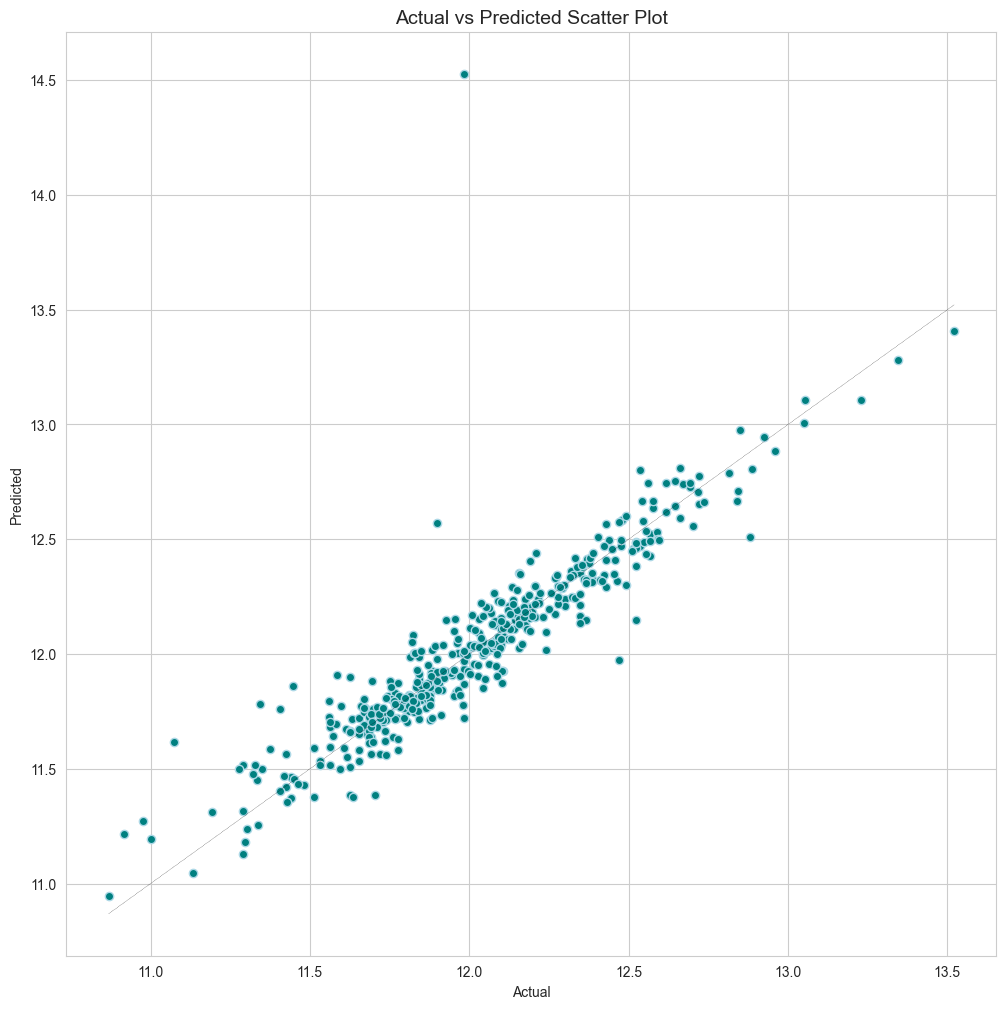

In [399]:
pred_vs_actual_plot(y_linear_pred_v, y_valid)

## 2. Ridge Model

In [400]:
alphas_ = [ 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20]

ridge = make_pipeline(MinMaxScaler(), RidgeCV(alphas=alphas_, cv=10))

In [401]:
cross_validation(ridge, X_train, y_train)

Pipeline Mean CV scores: 0.13068389742314057


In [402]:
ridge_model = ridge.fit(X_train, y_train)
y_ridge_pred = ridge_model.predict(X_train)
rmse(y_ridge_pred, y_train)

RMSE: 0.10425699129897091


In [403]:
y_ridge_pred_v = ridge_model.predict(X_valid)
rmse(y_ridge_pred_v, y_valid)

RMSE: 0.15199027427799314


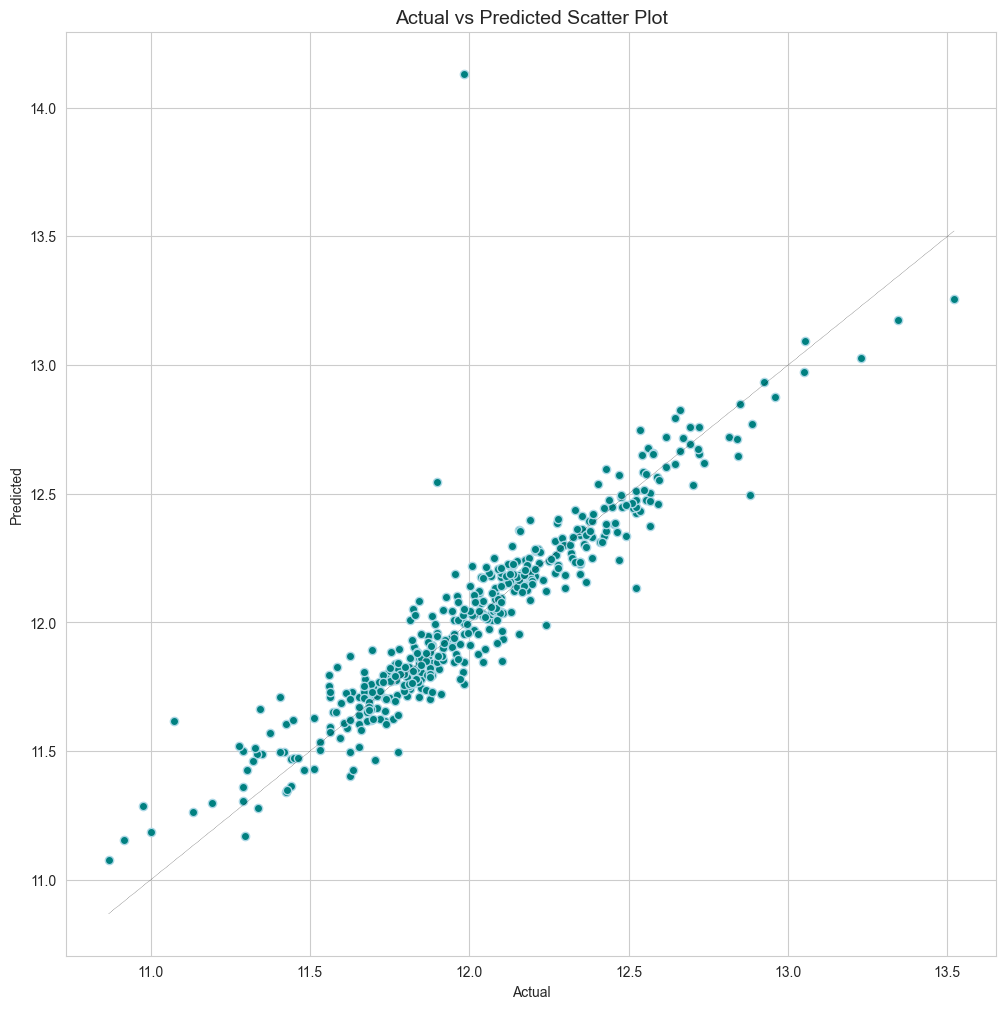

In [404]:
pred_vs_actual_plot(y_ridge_pred_v, y_valid)

# 3. Lasso Model

In [408]:
alpha2 = [0.0001, 0.0002, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

lasso = make_pipeline(RobustScaler(), LassoCV(alphas = alpha2, random_state=42,cv=12,max_iter=2000))

In [409]:
cross_validation(lasso, X_train, y_train)

c:\Users\hiepd\.conda\envs\ml_learning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03303840709448558, tolerance: 0.013763066540888895
  model = cd_fast.enet_coordinate_descent_gram(


Pipeline Mean CV scores: 0.13113428329183313


In [410]:
model_lasso = lasso.fit(X_train, y_train)

y_lasso_pred = model_lasso.predict(X_train)

rmse(y_lasso_pred, y_train)

RMSE: 0.10922943405777481


In [411]:
y_lasso_pred_v = model_lasso.predict(X_valid)

rmse(y_lasso_pred_v, y_valid)

RMSE: 0.16246834271973315


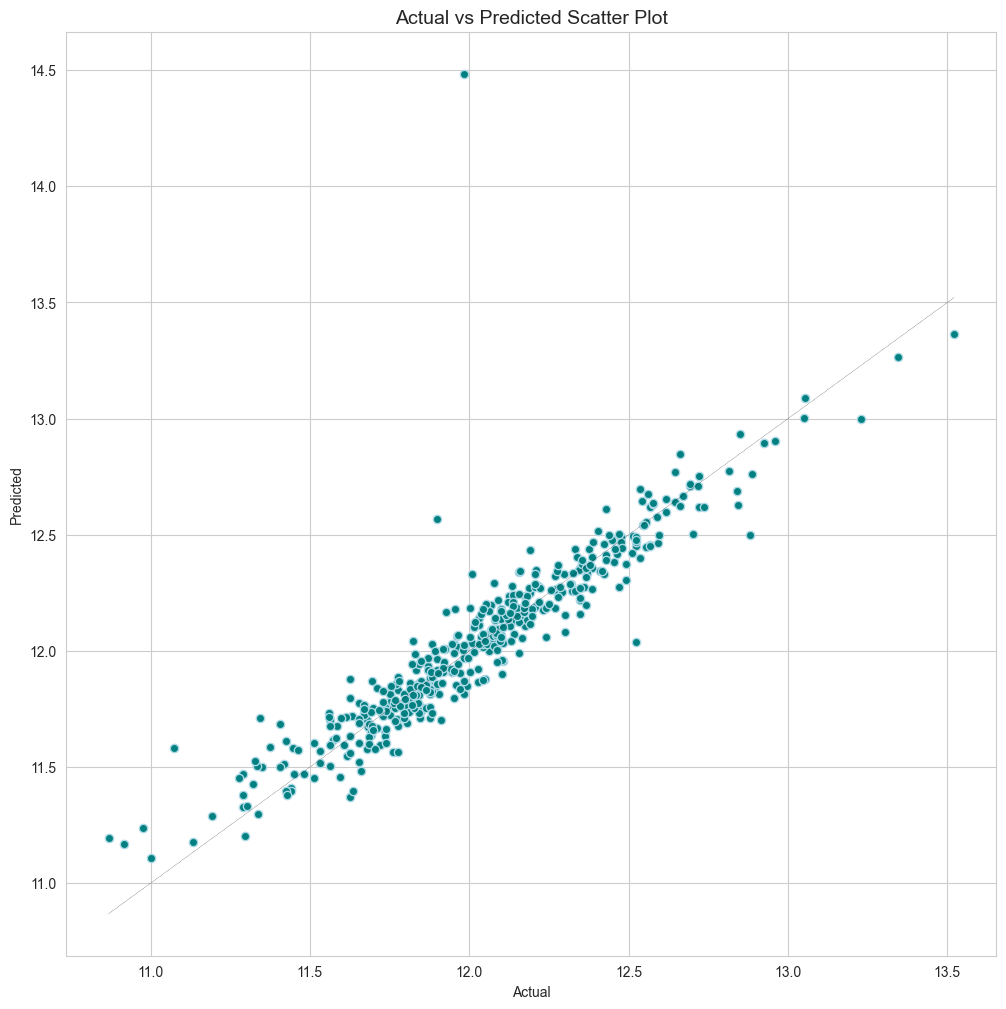

In [412]:
pred_vs_actual_plot(y_lasso_pred_v, y_valid)

## 4. K-nearest Neighbor Regression Model

In [413]:
neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=25)

neigh.fit(X_train, y_train)

y_neigh_pred = neigh.predict(X_train)

rmse(y_neigh_pred, y_train)

RMSE: 0.17553248510466096


In [414]:
neigh2 = KNeighborsRegressor(n_neighbors=7, weights='uniform', algorithm='auto', leaf_size=25)

neigh2.fit(X_train, y_train)

y_neigh2_pred = neigh2.predict(X_train)

rmse(y_neigh2_pred, y_train)

RMSE: 0.18523757974183064


In [416]:
neigh3 = KNeighborsRegressor(n_neighbors=9, weights='uniform', algorithm='auto', leaf_size=25)

neigh3.fit(X_train, y_train)

y_neigh3_pred = neigh3.predict(X_train)

rmse(y_neigh3_pred, y_train)

RMSE: 0.19146734806158877


In [417]:
y_neigh_pred_v = neigh.predict(X_valid)

rmse(y_neigh_pred_v, y_valid)

RMSE: 0.22646941230235468


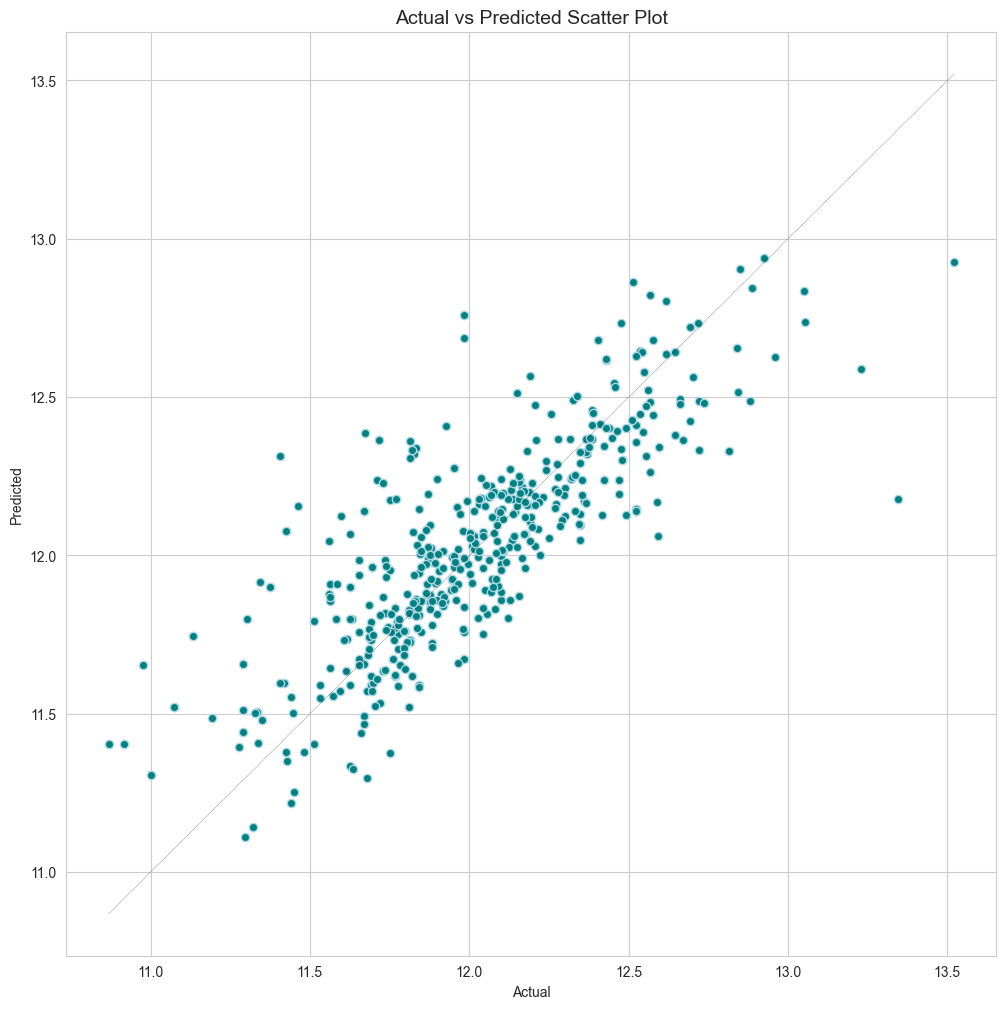

In [418]:
pred_vs_actual_plot(y_neigh_pred_v, y_valid)

## 5. Decision Tree Model

In [419]:
tree_regr1 = DecisionTreeRegressor(max_depth = 7, min_samples_leaf=5,random_state=42)

tree_regr2 = DecisionTreeRegressor(max_depth = 9,min_samples_leaf=9,random_state=42)

tree_regr11 = tree_regr1.fit(X_train,y_train)
tree_regr12 = tree_regr2.fit(X_train,y_train)

y1 = tree_regr1.predict(X_train)
y2 = tree_regr2.predict(X_train)

In [421]:
cross_validation(tree_regr1, X_train, y_train)
cross_validation(tree_regr2, X_train, y_train)

DecisionTreeRegressor Mean CV scores: 0.19474554983139383
DecisionTreeRegressor Mean CV scores: 0.18599682600941528


In [423]:
rmse(y1, y_train)
rmse(y2, y_train)

RMSE: 0.11389895099218225
RMSE: 0.12363856264939689


In [424]:
y_tree_valid = tree_regr2.predict(X_valid)

rmse(y_tree_valid, y_valid)

RMSE: 0.1856453811935606


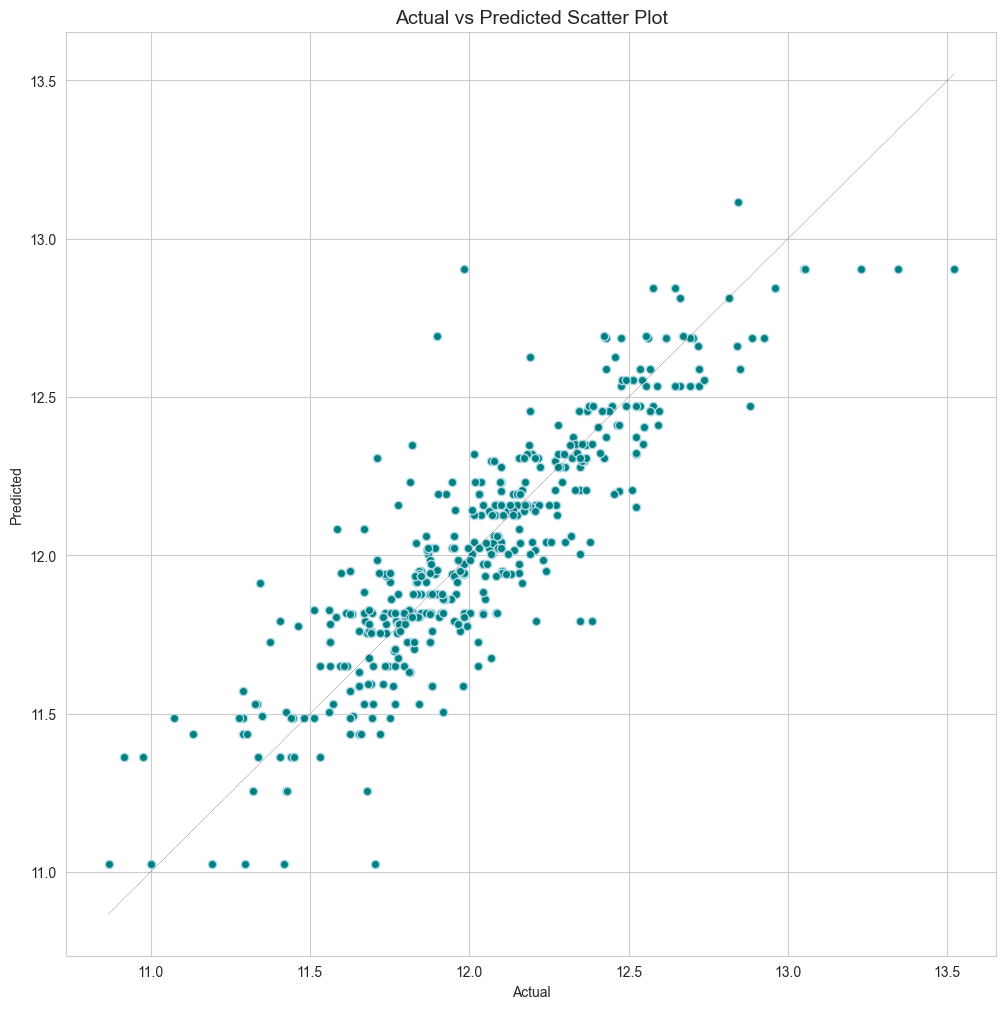

In [425]:
pred_vs_actual_plot(y_tree_valid, y_valid)

## 6. Random Forest Model

In [427]:
model_rf = RandomForestRegressor(n_estimators=200, max_depth=15,random_state=42)

param_grid  = {'n_estimators': [100,150,200,250,300,350,400],
               'max_depth': [5,7,9,11,13,15,17], 
               'min_samples_leaf': [3,5,7,9,11,13,15]}

grid_search = GridSearchCV(model_rf, param_grid = param_grid, cv = 5, n_jobs=-2)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [454]:
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=3, random_state=42)

cross_validation(rf, X_train, y_train)

RandomForestRegressor Mean CV scores: 0.1567284497263746


In [429]:
model_rf = rf.fit(X_train, y_train)

y_rf_pred = model_rf.predict(X_train)

rmse(y_rf_pred, y_train)

RMSE: 0.11914738899041705


In [430]:
y_rf_pred_v = model_rf.predict(X_valid)
rmse(y_rf_pred_v, y_valid)

RMSE: 0.1562367365827529


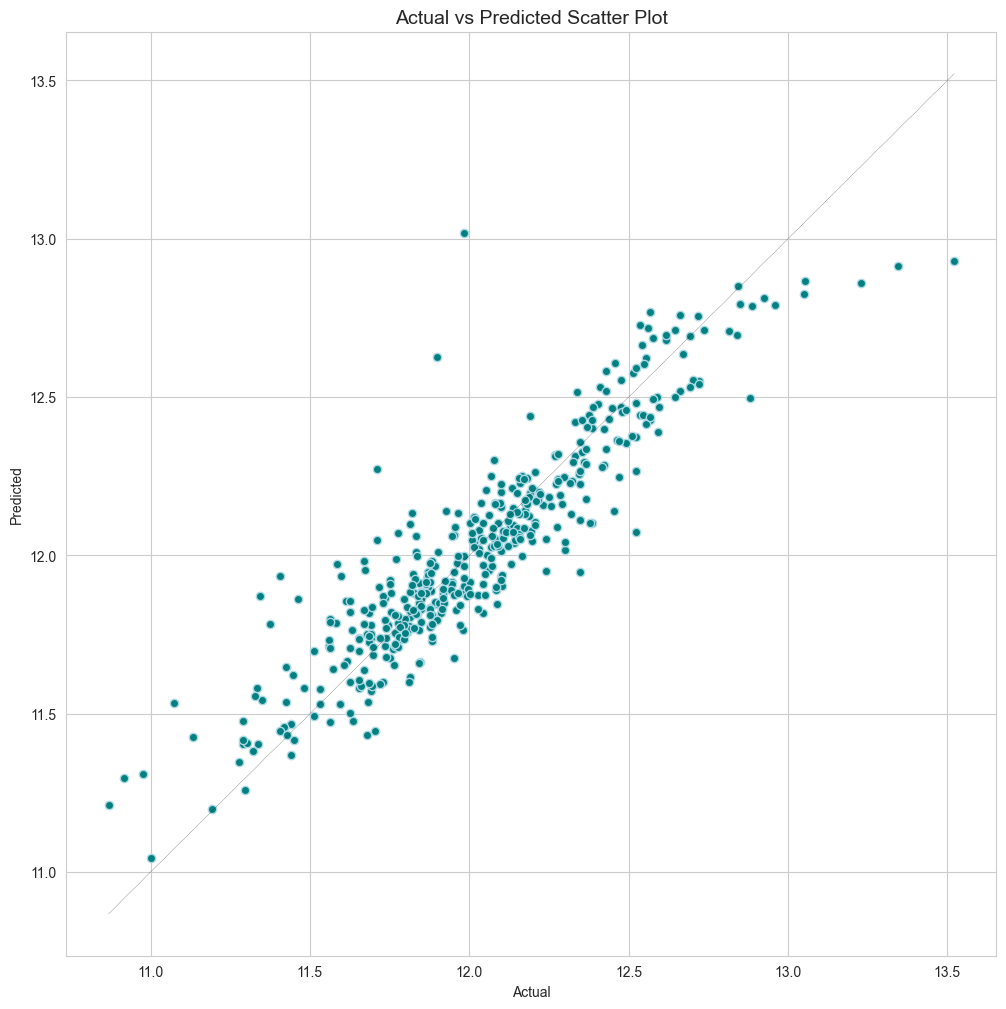

In [431]:
pred_vs_actual_plot(y_rf_pred_v, y_valid)

## 7. Support Vector Regressor Model

In [432]:
svr_basic = SVR(C = 10, gamma = 0.001)

In [433]:
param_grid  = {'C': [5,7,10,15,20,30],'gamma': [0.001, 0.0001, 0.0011, 0.00011], 'epsilon': [0.1, 0.01, 0.001, 0.005, 0.007, 0.008, 0.009] }

clf = GridSearchCV(svr_basic, param_grid, cv = 10, n_jobs = -2)
clf.fit(X_train,y_train)

KeyboardInterrupt: 

In [443]:
svr = make_pipeline(MinMaxScaler(), SVR(C= 5, epsilon= 0.1, gamma=0.0011, kernel = "rbf"))

In [444]:
cross_validation(svr_basic, X_train, y_train)

SVR Mean CV scores: 0.4032951395376764


In [445]:
model_svr = svr.fit(X_train, y_train)

y_svr_pred = model_svr.predict(X_train)

rmse(y_svr_pred, y_train)

RMSE: 0.12296253102258116


In [446]:
y_svr_pred_v = model_svr.predict(X_valid)

rmse(y_svr_pred_v, y_valid)

RMSE: 0.14911943033290626


In [ ]:
# Linear - 0.1804782973413552
# Sigmoid - 0.15172076086751377
# rbf - 0.14911943033290626

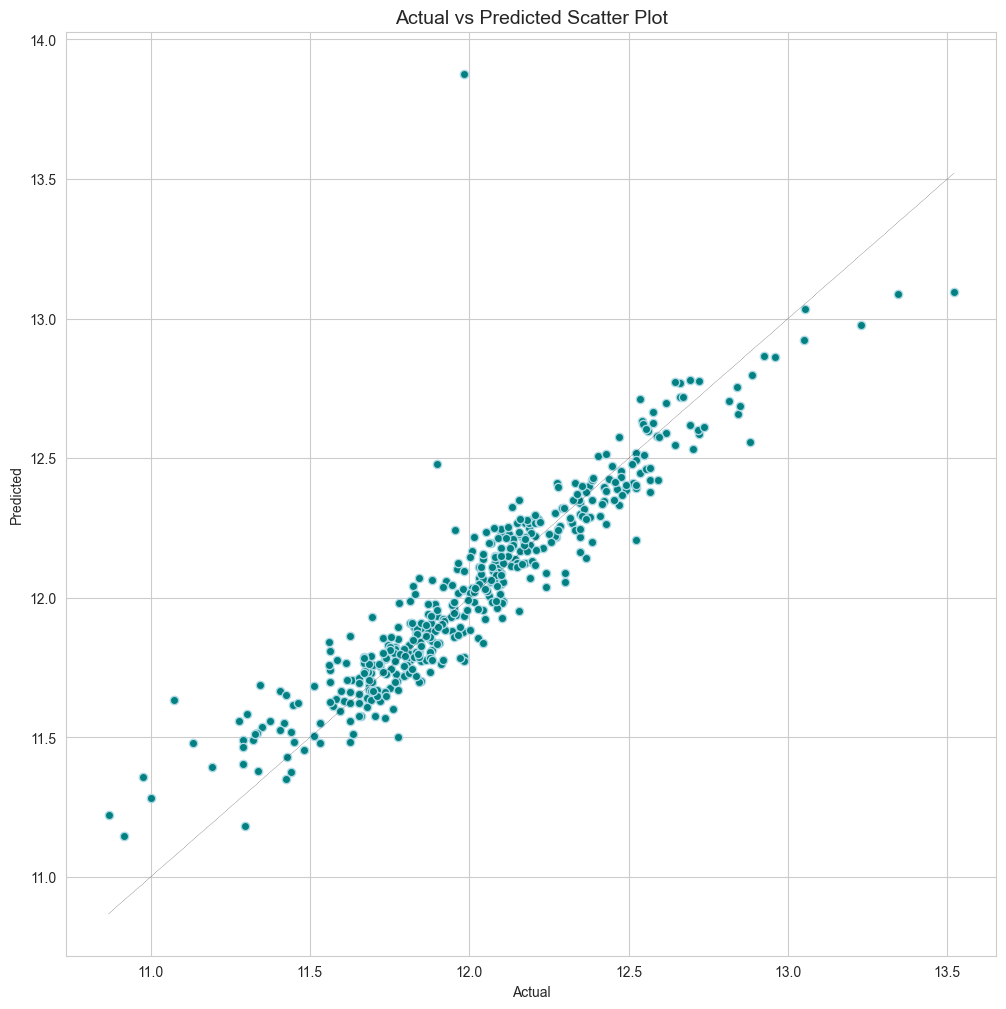

In [447]:
pred_vs_actual_plot(y_svr_pred_v, y_valid)

## 8. Gradient Boosting Regressor Model

In [448]:
gbr1 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth = 7,
                                min_samples_leaf=7, loss='huber', random_state =42) 

In [449]:
gbr2 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth = 9,
                                min_samples_leaf=10, loss='huber', random_state =42) 

In [451]:
cross_validation(gbr1, X_train, y_train)
cross_validation(gbr2, X_train, y_train)

GradientBoostingRegressor Mean CV scores: 0.14193379351771912
GradientBoostingRegressor Mean CV scores: 0.14056507772461477


In [452]:
model_gbr1 = gbr1.fit(X_train, y_train)
model_gbr2 = gbr2.fit(X_train, y_train)

#predict value of sale price on the training set
y_g1_pred = gbr1.predict(X_train)
y_g2_pred = gbr2.predict(X_train)

#caculate root mean square error
rmse(y_g1_pred,y_train)
rmse(y_g2_pred,y_train)

RMSE: 0.048972379746371315
RMSE: 0.05795784372416976


## 9. Stacked Regressor Model

In [455]:
estimators = [('Random Forest', rf),
              ("Support Vector Regressor",svr),
              ("K",neigh),
              ("Ridge",ridge)
              ]

In [456]:
stacked = StackingRegressor(estimators = estimators, final_estimator = rf, cv=5)

In [458]:
cross_validation(stacked, X_train, y_train)

KeyboardInterrupt: 

In [459]:
model_stack = stacked.fit(X_train, y_train)

y_stacked_pred = stacked.predict(X_train)

rmse(y_stacked_pred, y_train)

RMSE: 0.10072643470575593


In [460]:
y_stacked_pred_v = stacked.predict(X_valid)

rmse(y_stacked_pred_v, y_valid)

RMSE: 0.12626027979861662


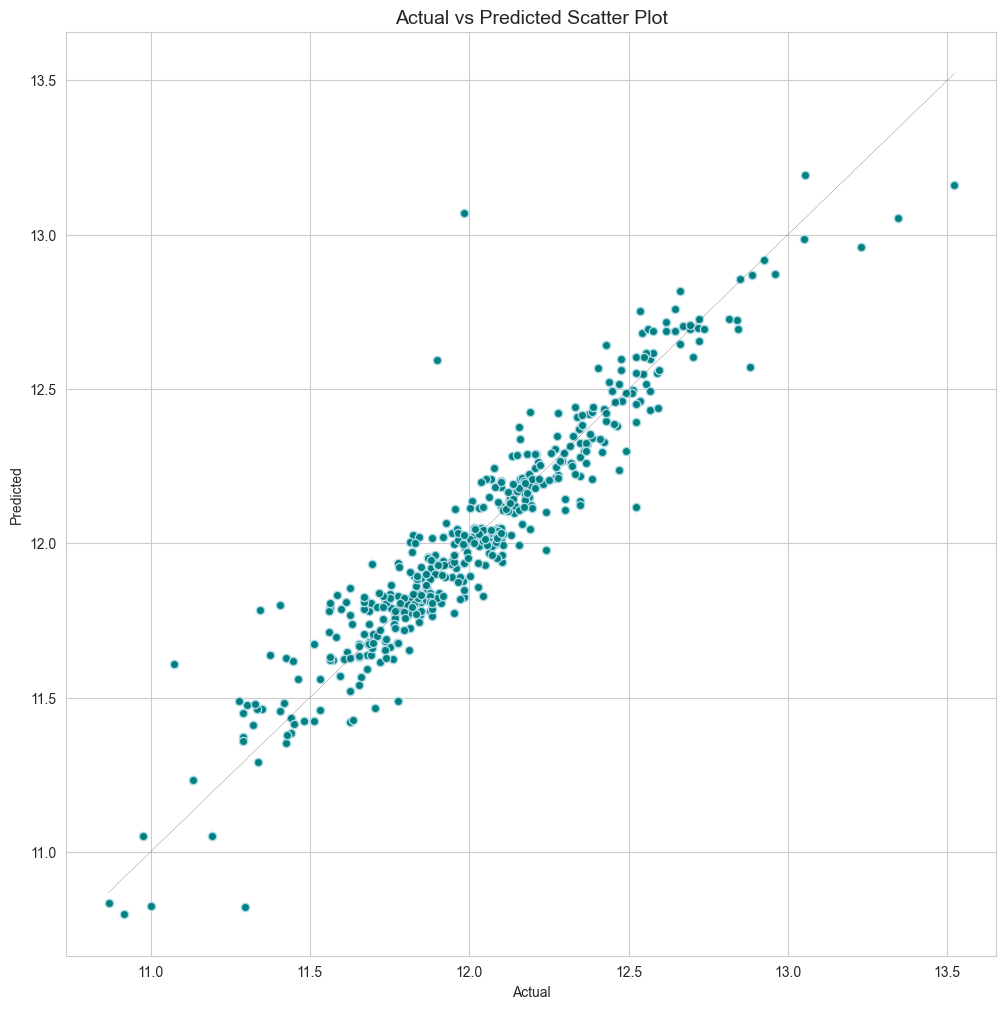

In [461]:
pred_vs_actual_plot(y_stacked_pred_v, y_valid)

In [475]:
output_path = r'submission.csv'

In [462]:
y_final_pred = model_stack.predict(X_test)

y_final_pred.shape

(1459,)

In [463]:
#undo the log tranformation to get predictions in terms of original label
predictions = np.expm1(y_final_pred)
print(predictions)

[114153.32984468 160419.11424415 170661.3954267  ... 166074.05108907
 116473.0041727  224510.2094232 ]


In [476]:
submit = pd.DataFrame()
submit['Id'] = test_id
submit['SalePrice'] = predictions
submit.to_csv(output_path, index=False)